In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [2]:
from simphony.libraries.analytic import CWLaser


wl = 1.55e-6
sampling_period =1e-14
T = 10000e-12
# T = 500e-12
N = int(T /sampling_period)
linewidth=0.2e12
t = jnp.arange(N)*sampling_period
cw_laser = CWLaser(wavelength=wl,linewidth=linewidth,lineshape='gaussian')

/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/gravis/_internal/plotting/template_system.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as _pkg_resources


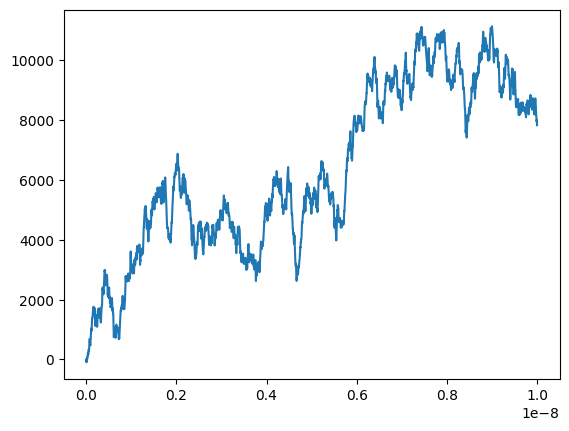

In [3]:
from simphony.simulation import SimulationParameters

sim_params = SimulationParameters(
    sampling_period=sampling_period,
    num_time_steps=N,
    prng_key=jax.random.key(5)
)


outputs = cw_laser.block_mode_response(simulation_parameters=sim_params)
A_t = outputs["o0"].amplitude[:,0,0]
phi = jnp.unwrap(jnp.angle(A_t))
plt.plot(t, 180 / jnp.pi * phi)
# plt.xlim(0, 1000)
# plt.ylim(-70, 70)

/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 1e-13)

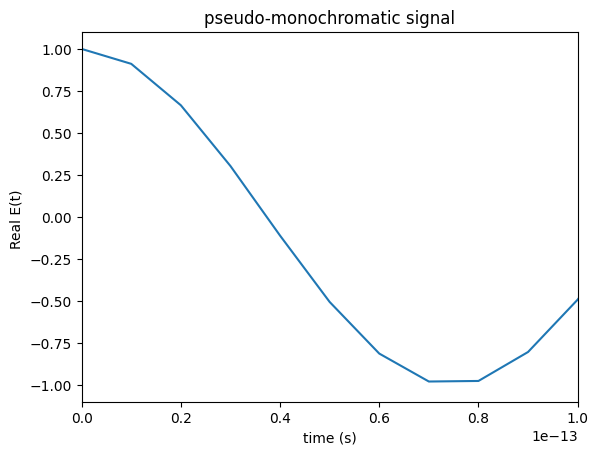

In [4]:
from scipy.constants import speed_of_light as C

E_t = A_t*jnp.exp(1j*2*jnp.pi*C/wl*t)

plt.plot(t, E_t)
plt.xlabel("time (s)")
plt.ylabel("Real E(t) ")
plt.title("pseudo-monochromatic signal")
plt.xlim([0, 0.1e-12])

/tmp/ipykernel_47970/3942998429.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


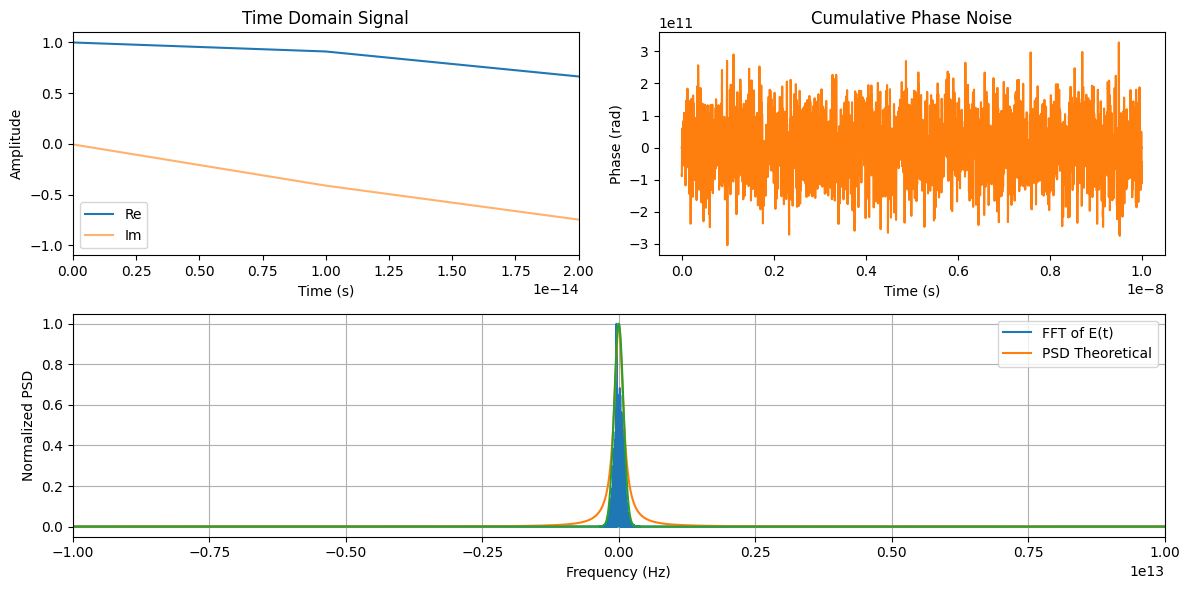

In [5]:
import numpy as np
from scipy.fftpack import fft, fftshift, fftfreq
# === Compute spectrum ===
E_f = fftshift(fft(np.array(A_t)))
freqs = fftshift(fftfreq(N, sampling_period))

# === Power spectral density (normalized) ===
psd = jnp.abs(E_f) ** 2
psd /= jnp.max(psd)  # Normalize for plotting

# === Plotting ===
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(t, jnp.real(E_t), label="Re")
plt.plot(t, jnp.imag(E_t), label="Im", alpha=0.6)
plt.title("Time Domain Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim([0, 0.02e-12])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t, jnp.unwrap(phi))
plt.plot(t[:-1], jnp.diff(phi)/(sampling_period*2*np.pi))
plt.title("Cumulative Phase Noise")
plt.xlabel("Time (s)")
plt.ylabel("Phase (rad)")

f = np.linspace(-100e12, 100e12, 10*N)

psd_theory = (1/(2*np.pi))*(linewidth)/((f)**2+(linewidth/2)**2)
psd_theory /= np.max(psd_theory)

psd_theory_gaussian = jnp.exp(-4*jnp.log(2)*(f/linewidth)**2)
# plt.plot(f, psd_theory)
# plt.show()

plt.subplot(2, 1, 2)
plt.plot(freqs, psd, label="FFT of E(t)")
plt.plot(f, psd_theory, label="PSD Theoretical")
plt.plot(f, psd_theory_gaussian)
# plt.plot(freqs/1e3, jnp.angle(E_f) ** 2)
# plt.title("Power Spectrum (Lorentzian Linewidth)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized PSD")
plt.xlim([-10e12, 10e12])
# plt.ylim([0, 1e-13])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


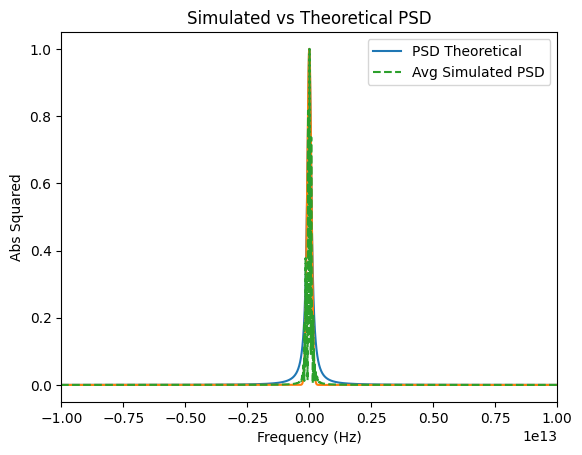

In [7]:
import numpy as np
E_f_list = []
fs = 1e15           # Sampling frequency (Hz)
T = 100e-12                # Total duration (s)
N = int(T * fs)           # Number of samples
t = np.arange(N) / fs     # Time array
for i in range(200):
    sim_params = SimulationParameters(
        sampling_period=1/fs,
        num_time_steps=N,
        prng_key=jax.random.key(i)
    )
    outputs = cw_laser.block_mode_response({}, sim_params)
    A_t = outputs["o0"].amplitude[:,0,0]
    phi = jnp.unwrap(jnp.angle(A_t))
    E_f_list.append(fftshift(fft(np.array(A_t))))

freqs = fftshift(fftfreq(N, 1/fs))
E_f = np.mean(np.array(E_f_list), axis=0)
psd = np.abs(E_f)**2
psd = psd / np.max(psd)
plt.plot(f, psd_theory, label="PSD Theoretical")
plt.plot(f, psd_theory_gaussian)
plt.plot(freqs, psd, linestyle="--", label="Avg Simulated PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Abs Squared")
plt.title("Simulated vs Theoretical PSD")
# plt.hlines(0.5, -linewidth/2, linewidth/2)
plt.xlim(-10e12, 10e12)
plt.legend()

Continuous Wave Lasers ideally produce coherent light at a one wavelength, $\lambda$. In general, random fluctuations in the phase and amplitude of the laser can introduce undesired wavelengths. If the power spectral density of the laser has a Lorentzian shape, then we usually characterize the laser by its linewdith $\delta f$ (the full-width half max of the PSD). 

Such light corresponds to the following time domain signals of the following form.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light, epsilon_0

fs = 1e16             # Sampling frequency (Hz)
T = 100e-12                # Total duration (s)
N = int(T * fs)           # Number of samples
t = np.arange(N) / fs     # Time array
f0 = 193e12               # Carrier frequency (Hz)
fb = f0                   # Baseband frequency (Hz)
linewidth = 2e12         # Lorentzian FWHM (Hz)

delta_phi_std = np.sqrt(2*np.pi * linewidth / fs)
dphi = np.random.randn(N) * delta_phi_std
phi = np.cumsum(dphi)  # Integrate to get phase

# === Generate signal: constant amplitude with noisy phase ===
A_t = np.exp(1j * (2 * np.pi * (f0-fb) * t + phi))
E_t = A_t*np.exp(1j*2*np.pi*f0*t)

plt.plot(t, E_t)
plt.xlim([0, 0.02e-12])
N

In [ ]:
# f_0 = 0 # Shift to baseband

f = np.linspace(-100e12, 100e12, 10*N)

psd_theory = (1/(2*np.pi))*(linewidth)/((f)**2+(linewidth/2)**2)
psd_theory /= np.max(psd_theory)
plt.plot(f, psd_theory)
plt.show()

In [ ]:
from scipy.fftpack import fft, fftshift, fftfreq
# === Compute spectrum ===
E_f = fftshift(fft(A_t))
freqs = fftshift(fftfreq(N, 1/fs))

# === Power spectral density (normalized) ===
psd = np.abs(E_f) ** 2
psd /= np.max(psd)  # Normalize for plotting

# === Plotting ===
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(t, np.real(E_t), label="Re")
plt.plot(t, np.imag(E_t), label="Im", alpha=0.6)
plt.title("Time Domain Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim([0, 0.05e-12])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t, np.unwrap(phi))
plt.title("Cumulative Phase Noise")
plt.xlabel("Time (s)")
plt.ylabel("Phase (rad)")

plt.subplot(2, 1, 2)
plt.plot(freqs, psd)
plt.plot(f, psd_theory)
# plt.plot(freqs/1e3, np.angle(E_f) ** 2)
plt.title("Power Spectrum (Lorentzian Linewidth)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized PSD")
plt.xlim([-10e12, 10e12])
# plt.ylim([0, 1e-13])
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
E_f_list = []
fs = 1e14             # Sampling frequency (Hz)
T = 10e-12                # Total duration (s)
N = int(T * fs)           # Number of samples
t = np.arange(N) / fs     # Time array
for i in range(5000):
    delta_phi_std = np.sqrt(2*np.pi * linewidth / fs)
    dphi = np.random.randn(N) * delta_phi_std
    phi = np.cumsum(dphi)  # Integrate to get phase
    A_t = np.exp(1j * (2 * np.pi * (f0-fb) * t + phi))
    E_f_list.append(fftshift(fft(A_t)))

freqs = fftshift(fftfreq(N, 1/fs))
E_f = np.mean(np.array(E_f_list), axis=0)
psd = np.abs(E_f)**2
psd = psd / np.max(psd)
plt.plot(f, psd_theory)
plt.plot(freqs, psd)
# plt.hlines(0.5, -linewidth/2, linewidth/2)
plt.xlim(-10e12, 10e12)


# Gaussian Linewidth

In [ ]:
from scipy.signal.windows import gaussian
E_f_list = []
fs = 1e14             # Sampling frequency (Hz)
T = 10e-12                # Total duration (s)
N = int(T * fs)           # Number of samples
t = np.arange(N) / fs     # Time array

window_width = int(N // 100)  # Control PSD width
gaussian_window = gaussian(N, std=window_width/2)
gaussian_window /= np.sum(gaussian_window)
# phi_gauss = np.convolve(noise, gaussian_window, mode='same')
for i in range(10000):
    delta_phi_std = 0.5
    dphi = np.random.randn(N) * delta_phi_std
    dphi = np.convolve(dphi, gaussian_window)[N//2:3*N//2]
    phi = np.cumsum(dphi)  # Integrate to get phase
    # phi *= 0.5
    A_t = np.exp(1j * (2 * np.pi * (f0-fb) * t + phi))
    E_f_list.append(fftshift(fft(A_t)))

freqs = fftshift(fftfreq(N, 1/fs))
E_f = np.mean(np.array(E_f_list), axis=0)
psd = np.abs(E_f)**2
psd = psd / np.max(psd)
plt.plot(f, gaussian(len(f), std=100000))
plt.plot(freqs, psd)
# plt.hlines(0.5, -linewidth/2, linewidth/2)
plt.xlim(-10e12, 10e12)

In [ ]:
plt.plot(dphi)